# Prediction of Compressive Stength Using Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import data_transformation as trans
%matplotlib inline

ModuleNotFoundError: No module named 'seaborn'

## Dataset Loading, Handling of Empty Entries, Aggregating, Unpivoting

### Uploading of the data

In [7]:
data = pd.read_excel("pevnosti_uprava_tabulky.xlsx", index_col=None,sheet_name="Aggregated_Data")

In [8]:
data.sample(5)

,ID,CemType,CemAmt,FlyAsh,Limestone,Microsil,MicrosilSuspen,CleanWater,SludgeWater,Plast,...,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63
14,15,"CEM I 42,5 R",475,21.0,NaN,NaN,NaN,190.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,39,"CEM I 42,5 R",400,NaN,NaN,15.0,NaN,135.0,40.0,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,129,"CEM II/B-S 32,5 R",345,40.0,NaN,NaN,NaN,NaN,185.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,150,"CEM III/B 32,5 N SR",360,60.0,NaN,NaN,NaN,140.0,50.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,115,"CEM II/B-S 32,5 R",360,50.0,NaN,NaN,NaN,130.0,50.0,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Variables
The original dataset has 22 variabels in total. It consists of:

- ID: the identifier of the specific mixture that was tested, i.e., one ID for n-testing ages, numeric
- CemType: Type of cement, categorical
- CemAmt: Amount of cement per m^3 of concrete [kg/m^3]
- FlyAsh: Amount of fly-ash per m^3 of concrete [kg/m^3]
- Limestone: Amount of limestone per m^3 of concrete [kg/m^3]
- Microsilica: Amount of microsilica per m^3 of concrete [kg/m^3]
- Microsilica suspension: Amount of microsilica suspension per m^3 of concrete [kg/m^3]
- CleanWater: Amount of clean mixing water per m^3 of concrete [kg/m^3]
- SludgeWater: Amount of sludge mixing water per m^3 of concrete [kg/m^3]
- Plast: Amount of plasticizer per m^3 of concrete [kg/m^3]
- Superplast: Amount of superplasticizer per m^3 of concrete [kg/m^3]
- AirEntrainer: Amount of air entrainer per m^3 of concrete [kg/m^3]
- Retarder: Amount of set retarder per m^3 of concrete [kg/m^3]
- Accelerator: Amount of set accelerator per m^3 of concrete [kg/m^3]
- ShrinkageReducer: Amount of shrinkage control admixture per m^3 of concrete [kg/m^3]
- Stabilizer: Amount of stabilizing admixture per m^3 of concrete [kg/m^3]
- Crystalizer: Amount of crystalline admixture per m^3 of concrete [kg/m^3]
- Crystalizer: Amount of slump retaining admixture per m^3 of concrete [kg/m^3]
- Agg_0_n: Amount of aggregates per m^3 of concrete [kg/m^3]
- PPFibres: Amount of PP fibres per m^3 of concrete [kg/m^3]
- GlassFibres: Amount of glass fibres per m^3 of concrete [kg/m^3]
- **Day_n: The compressive strength measured at the given day from casting [MPa]**

### Handeling of empty entries
Empty entries in all variables which represent dosage per m3 of concrete will be replaced by 0 (i.e. zero dose of the substance).

In [10]:
filter_day_col = [col for col in data if col.startswith('Day')]

In [11]:
#Handling of missing data
nan_fill_zero = [col for col in data if col not in filter_day_col]
data[nan_fill_zero] = data[nan_fill_zero].fillna(0)

In [12]:
data.sample(2)

,ID,CemType,CemAmt,FlyAsh,Limestone,Microsil,MicrosilSuspen,CleanWater,SludgeWater,Plast,...,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63
149,150,"CEM III/B 32,5 N SR",360,60.0,0.0,0.0,0.0,140.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,20,"CEM I 42,5 R",455,0.0,0.0,0.0,30.0,165.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data = data[data["CemType"] != "CEM III/B 32,5 L SR"] #too little entries (1)

### Aggregation of the concrete components

Selected variables are aggregated into water, fine aggregates, coarse aggregates, admixtures, additives, fibres, and microsilica. Some of the original variables (clean/sludge water, aggregates, PP and glass fibres, microsilica and microsilica suspension) are dropped from the DataFrame.

In [14]:
data = trans.DataTransformatorPipeline.sum_water_agg_admix_add_fibres_microsil(data)

Variables were aggregated and selected dropped.


### Unpivoting the dataset
The information about the testing age (Day_1, Day_2,...) and respective compressive strength (fc) will be transfered into new columns, while keeping the remaining variables as identifiers. Rows, where the compressive strength (fc) value is missing will be dropped from the dataset – no testing at the given age.

In [105]:
id_col = [col for col in data if col not in filter_day_col]
col_melt = filter_day_col
data_melted = data.melt(id_vars=id_col, value_vars= col_melt, var_name = "Age", value_name = "fc")

In [106]:
data_melted["Age"] = data_melted.Age.str.split("_",expand=True)[1].astype(int)

In [107]:
data_melted.dropna(subset = ["fc"],inplace=True)
data_melted.reset_index(drop=True,inplace=True)

In [108]:
data_melted.sample(2)

,ID,CemType,CemAmt,FlyAsh,Limestone,Plast,Superplast,AirEntrainer,Retarder,Accelerator,...,SlumpRetention,TotalWater,FineAgg,CoarseAgg,Admixtures,Additives,Fibres,Microsil_MicrosilSuspen,Age,fc
87,50,"CEM I 42,5 R",390,0.0,0.0,0.0,3.30,0.6,0.0,0.0,...,0.0,160.0,810.0,1030.0,3.90,0.0,0.0,0.0,2,31.6
505,116,"CEM II/B-S 32,5 R",360,50.0,0.0,0.0,2.25,0.0,0.0,0.0,...,0.0,190.0,885.0,840.0,2.25,50.0,0.0,0.0,28,48.5


### Dealing with testing age
Some days are underrepresented – ages close together will be aggregated.

In [109]:
#Original ages
data_melted.groupby("Age").size()

Age
1       49
2      135
3       50
4        5
5        4
7      137
8       17
9        1
14       9
27       1
28     138
29      16
30       1
56       5
59       3
90     156
123      1
179      4
181      3
182      3
189      2
190      1
360      4
dtype: int64

In [110]:
#Age 189,190 will be set to 189
data_melted["Age"] = data_melted["Age"].apply(lambda x: 189 if x in [189, 190] else x)

In [111]:
#Age 181,182 will be set to 181
data_melted["Age"] = data_melted["Age"].apply(lambda x: 181 if x in [181, 182] else x)

In [112]:
#Age 29, 30 will be set to 29
data_melted["Age"] = data_melted["Age"].apply(lambda x: 29 if x in [29,30] else x)

In [113]:
#Age 27, 28 will be switched to 28
data_melted["Age"] = data_melted["Age"].apply(lambda x: 28 if x in [27,28] else x)

In [114]:
#Age 123 droped
data_melted = data_melted[data_melted["Age"] != 123]

In [115]:
#Ages after aggregation
data_melted.groupby("Age").size()

Age
1       49
2      135
3       50
4        5
5        4
7      137
8       17
9        1
14       9
28     139
29      17
56       5
59       3
90     156
179      4
181      6
189      3
360      4
dtype: int64

In [116]:
#Chosen ages: 1,2,3,7,8,14,28,29,90
data_melted = data_melted[data_melted["Age"].isin([1,2,3,7,8,14,28,29,90])]

In [117]:
#Ages after aggregation
data_melted.groupby("Age").size()

Age
1      49
2     135
3      50
7     137
8      17
14      9
28    139
29     17
90    156
dtype: int64

## Exploratory Data Analysis
Herein, a brief overview of the dataset is presented.

In [118]:
data_melted.describe()

,ID,CemAmt,FlyAsh,Limestone,Plast,Superplast,AirEntrainer,Retarder,Accelerator,ShrinkageReducer,...,SlumpRetention,TotalWater,FineAgg,CoarseAgg,Admixtures,Additives,Fibres,Microsil_MicrosilSuspen,Age,fc
count,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,...,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000
mean,79.476728,372.440056,28.531735,7.129760,0.914880,2.017024,0.090324,0.043724,0.018618,0.042313,...,0.022849,180.678420,1036.692525,729.455571,3.294584,36.232722,0.056700,0.571227,28.370945,36.849177
std,45.903252,52.149133,33.306031,31.238197,1.139429,1.418828,0.210749,0.178088,0.201668,0.502438,...,0.201652,11.905387,183.804424,200.827461,1.272612,46.058864,0.222469,3.904520,34.172945,17.652488
min,1.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,155.000000,755.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,39.000000,340.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,175.000000,925.000000,650.000000,2.400000,0.000000,0.000000,0.000000,2.000000,23.900000
50%,80.000000,370.000000,20.000000,0.000000,0.000000,2.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,180.000000,1010.000000,770.000000,3.000000,21.000000,0.000000,0.000000,7.000000,38.100000
75%,120.000000,405.000000,50.000000,0.000000,1.900000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,190.000000,1130.000000,845.000000,3.900000,55.000000,0.000000,0.000000,28.000000,48.250000
max,156.000000,475.000000,140.000000,185.000000,3.700000,5.400000,0.790000,2.000000,2.200000,6.000000,...,1.800000,210.000000,1840.000000,1040.000000,9.650000,230.000000,1.000000,30.000000,90.000000,91.100000


### Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b1feef810>,
      dtype=object)

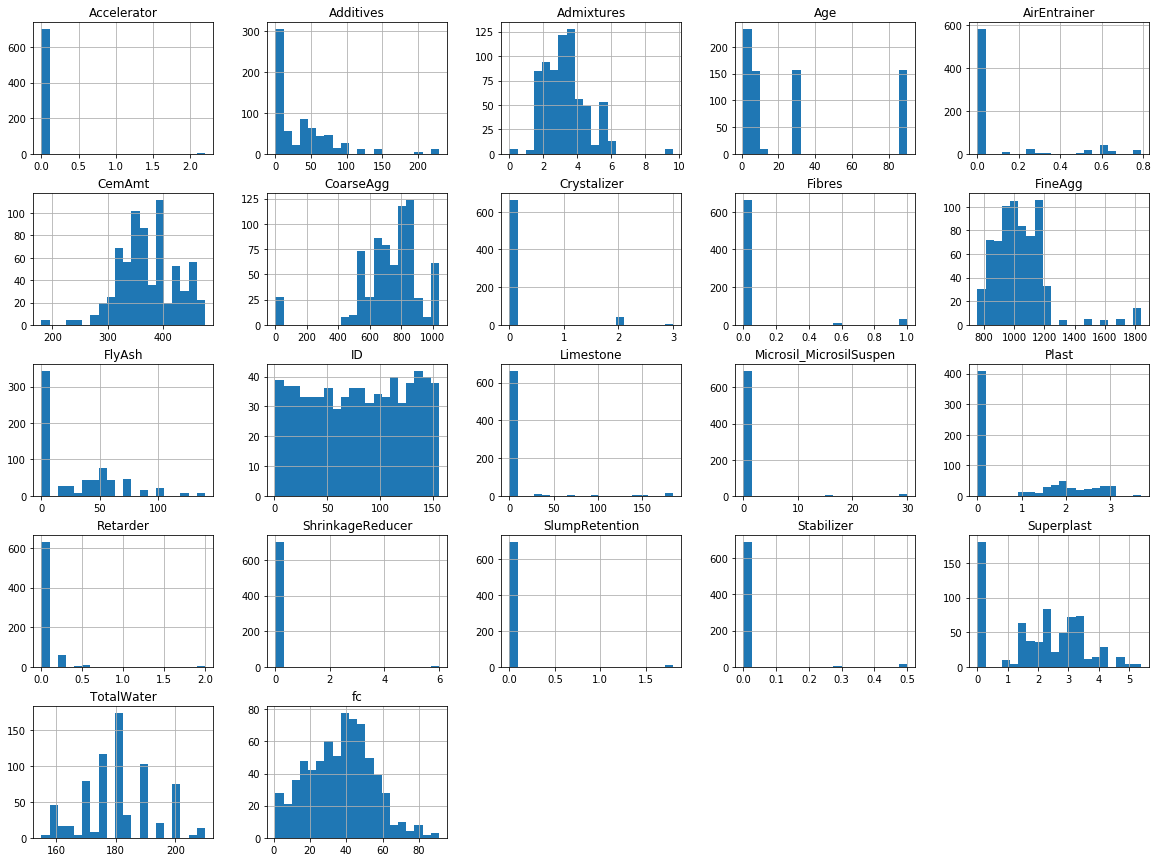

In [119]:
data_melted.hist(bins=20,figsize=(20,15))

[Text(0, 0.5, 'Number of records'), Text(0.5, 0, 'Days from casting')]

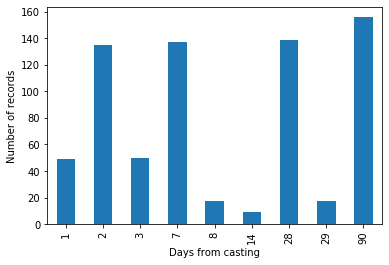

In [120]:
ax = data_melted.groupby("Age").size().plot.bar(color = "tab:blue")
ax.set(xlabel="Days from casting", ylabel="Number of records")

### Pearson's correlation
Based on the plots below, it can be seen that there is a potential linear relationship between some variables and the compressive strength (fc). In accordance with the assumptions, higher correlation coefficients can be seen primarily in the case of the amount of cement, admixtures, and plasticizers.

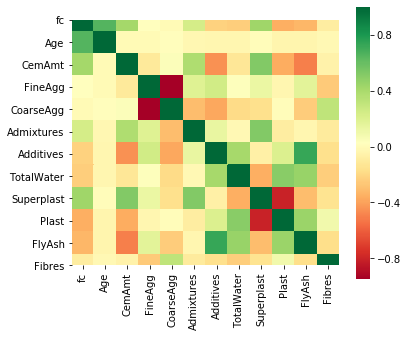

In [121]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(data_melted[["fc","Age","CemAmt","FineAgg","CoarseAgg","Admixtures","Additives","TotalWater","Superplast","Plast","FlyAsh","Fibres"]].corr(), square=True, cmap='RdYlGn', ax=ax)

In [122]:
#Pearons correlation coeficients
data_melted.corr()["fc"].sort_values(ascending=False)

fc                         1.000000
Age                        0.654216
Superplast                 0.435537
CemAmt                     0.421916
Admixtures                 0.238282
AirEntrainer               0.139602
SlumpRetention             0.132028
Microsil_MicrosilSuspen    0.081316
Stabilizer                 0.064210
Accelerator                0.054471
Retarder                   0.049010
Crystalizer                0.031090
FineAgg                    0.023809
Limestone                  0.008866
CoarseAgg                 -0.004464
ShrinkageReducer          -0.009599
Fibres                    -0.079630
Additives                 -0.222319
TotalWater                -0.237069
FlyAsh                    -0.325294
Plast                     -0.356736
ID                        -0.492698
Name: fc, dtype: float64

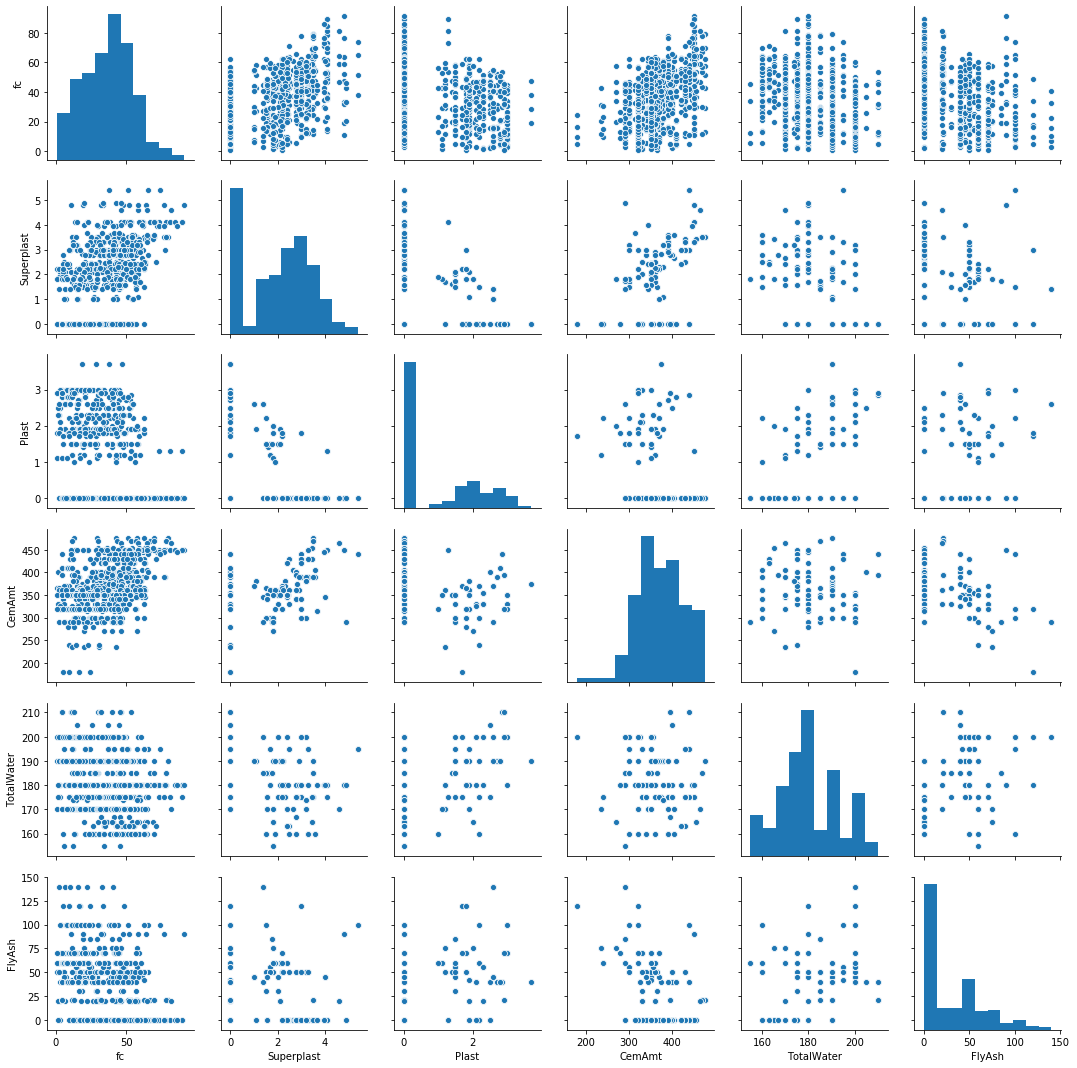

In [123]:
sns.pairplot(data_melted[["fc","Superplast","Plast","CemAmt","TotalWater","FlyAsh"]])

## Data Transformation

In [124]:
data_trans = data_melted.copy()

### Dropping of features with little impact on the compressive strength

In [125]:
data_trans = trans.DataTransformatorPipeline.drop_insignificant_variables(data_trans)

Insignificant variables ('ShrinkageReducer','Stabilizer','SlumpRetention','Crystalizer') were dropped.


### Data set preparation for CatBoost

In [126]:
data_catboost = data_trans.copy()

In [127]:
#Logaritmization of CemAmt, TotalWater and Compressive strength fc (target variable)
data_catboost = trans.DataTransformatorPipeline.make_log_columns(data_catboost,["CemAmt","TotalWater","fc"])

['CemAmt', 'TotalWater', 'fc'] variables were logarithmized and original variables dropped.


In [128]:
#Interactions of Age with other selected variables
data_catboost = trans.DataTransformatorPipeline.make_interactions(data_catboost,"Age",["ID","CemType","Age","fc_log"])

Interactions (product) of Age and all variables apart from ['ID', 'CemType', 'Age', 'fc_log'] were made and original variables dropped.


In [129]:
#Unification of mixtures with the same composition under a common id
groupby_cols_cat = list(set(data_catboost.columns.to_numpy())- set("ID fc_log".split()))
d_cat = data_catboost.drop(columns=["fc_log"]).sort_values(groupby_cols_cat).groupby(groupby_cols_cat).first().rename(columns={"ID":"id.new"})
data_catboost_union = pd.merge(data_catboost,d_cat,how='inner',left_on=groupby_cols_cat,right_on=groupby_cols_cat)
data_catboost_union["ID"] = data_catboost_union["id.new"]
data_catboost_union.drop(columns=["id.new"],inplace=True)

### Data set preparation for DT, RF, XGBoost: Handeling categorical values

In [130]:
#CemType to dummy variables
data_trans = pd.get_dummies(data_trans.copy(), columns={"CemType"},drop_first=True)

In [131]:
#Logaritmization of CemAmt, TotalWater and Compressive strength fc (target variable)
data_trans = trans.DataTransformatorPipeline.make_log_columns(data_trans,["CemAmt","TotalWater","fc"])

['CemAmt', 'TotalWater', 'fc'] variables were logarithmized and original variables dropped.


In [132]:
#Interactions of Age with other selected variables
data_trans = trans.DataTransformatorPipeline.make_interactions(data_trans,"Age",["ID","Age","fc_log"])

Interactions (product) of Age and all variables apart from ['ID', 'Age', 'fc_log'] were made and original variables dropped.


In [133]:
#Unification of mixtures with the same composition under a common id
groupby_cols = list(set(data_trans.columns.to_numpy())- set("ID fc_log".split()))
d = data_trans.drop(columns=["fc_log"]).sort_values(groupby_cols).groupby(groupby_cols).first().rename(columns={"ID":"id.new"})
data_trans_union = pd.merge(data_trans,d,how='inner',left_on=groupby_cols,right_on=groupby_cols)
data_trans_union["ID"] = data_trans_union["id.new"]
data_trans_union.drop(columns=["id.new"],inplace=True)

In [134]:
%config Completer.use_jedi = False

## Model Selection, Training and Predictions

In [135]:
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.tree import plot_tree
from sklearn.model_selection import GroupShuffleSplit,GroupKFold
from operator import attrgetter
from typing import Tuple
from catboost import CatBoostRegressor

### Dataset applied for the modeling
Data are splitted in a train and test set in a way that mixes (one mix is tested in various ages) is grouped and is not divided into test and train test. The spilt is also stratified by the testing age.

In [136]:
class Model_Data:
    
    def __init__(self,name,df):
        self.name = name
        self.df = df
        self.X_train = pd.DataFrame(data=None)
        self.y_train = 0
        self.X_test = pd.DataFrame(data=None)
        self.y_test = 0
        self.predictions = 0
        self.applied_age = "all"
    
    def X_y_split(self,df):
        X = df.drop(columns="fc_log")
        y = np.array(df["fc_log"])
        return X,y
    
    def stratified_group_train_test_split(self,test_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
        samples = self.df
        group = "ID"
        stratify_by = "Age"
        groups = samples[group].drop_duplicates()
        stratify = samples.drop_duplicates(group)[stratify_by].to_numpy()
        groups_train, groups_test = train_test_split(groups, stratify=stratify, test_size=test_size,random_state=42)

        samples_train = samples.loc[lambda d: d[group].isin(groups_train)]
        samples_test = samples.loc[lambda d: d[group].isin(groups_test)]

        self.X_train,self.y_train = self.X_y_split(samples_train)
        self.X_test,self.y_test = self.X_y_split(samples_test)
        
    def select_age(self,age):
        self.df = self.df.query(f"Age == {age}")
        self.applied_age = age
        
    def get_X_y_for_age(self, orig_model_data):
        id_train_age = orig_model_data.X_train.copy().query(f"Age == {self.applied_age}")["ID"]
        id_test_age = orig_model_data.X_test.copy().query(f"Age == {self.applied_age}")["ID"]
        train_age = self.df.loc[self.df["ID"].isin(id_train_age)]
        test_age = self.df.loc[self.df["ID"].isin(id_test_age)]
        self.X_train,self.y_train = self.X_y_split(train_age)
        self.X_test,self.y_test = self.X_y_split(test_age)

In [137]:
model_data = Model_Data("Data for dt, rf, XGBoost",df=data_trans_union.copy())
model_data.stratified_group_train_test_split(0.2)

In [138]:
model_data_cat = Model_Data("Data for CatBoost",df=data_catboost_union.copy())
model_data_cat.stratified_group_train_test_split(0.2)

### Model Training and Evaluation Using All Ages

In [139]:
class ModelCharacteristics:
    
    def __init__(self,name,pipeline,params):
        self.name = name
        self.params = params
        self.pipeline = pipeline
        
        
class ModelTrainerEvaluator:
    
    def __init__(self,model_char):
        self.model_char = model_char
        self.model_data = None
        self.grid_search = 0
        self.best_estimator = 0
        self.MAE = 0
        self.MSE = 0
        self.RMSE = 0
        self.R2 = 0
    
    def gridsearchcv_fit_predict_evaluate(self,model_data,exclude_columns):
        X_train = model_data.X_train
        y_train = model_data.y_train
        X_test = model_data.X_test
        y_test = model_data.y_test
        
        groups = np.array(X_train["ID"])
        gkf = GroupKFold(n_splits = 5)
        self.grid_search = GridSearchCV(self.model_char.pipeline, 
                                        self.model_char.params, 
                                        cv=gkf, 
                                        scoring="neg_mean_squared_error",
                                        n_jobs=-1)
        #Fitting without ID and Age
        self.grid_search.fit(X_train.drop(columns= exclude_columns),y_train,groups=groups)
        self.best_estimator = self.grid_search.best_estimator_
        
        #Predicting without ID and Age (prediction of log(fc))
        predictions = self.best_estimator.predict(X_test.drop(columns=exclude_columns))
        
        #Metrics
        self.MAE = mean_absolute_error(np.exp(y_test),np.exp(predictions))
        self.MSE = mean_squared_error(np.exp(y_test),np.exp(predictions))
        self.RMSE = self.MSE**0.5
        self.R2 = r2_score(np.exp(y_test),np.exp(predictions))
        
        self.model_data = model_data
        self.model_data.predictions = predictions
    
    def print_gridsearch_evaluation(self):
        params = self.grid_search.best_params_
        cvMSE = -1*self.grid_search.best_score_
        MAE = self.MAE
        MSE = self.MSE
        RMSE = self.RMSE
        R2 = self.R2
        model_name = self.model_char.name
        dataset_name = self.model_data.name
        print(f"{model_name} using {dataset_name}")
        print(f"best parameters: {params}")
        print(f"best cv MSE (log): {cvMSE.round(3)}")
        print(f"MSE on test dataset: {MSE.round(3)} MPa^2")
        print(f"RMSE on test dataset: {RMSE.round(3)} MPa")
        print(f"MAE on test dataset: {MAE.round(3)} MPa")
        print(f"R2 score on test dataset: {R2.round(3)}")
        print("")
    
    def get_subsample_age_evaluation(self,age):
        sub_df = self.model_data.X_test.copy()
        sub_df["fc_measured"] = np.exp(self.model_data.y_test.copy())
        sub_df["fc_predicted"] = np.exp(self.model_data.predictions.copy())
        sub_df = sub_df.query(f"Age == {age}").copy()
        if len(sub_df) != 0:
            sub_df["AE"] = np.abs(sub_df["fc_predicted"] - sub_df["fc_measured"])
            subMSE = mean_squared_error(sub_df["fc_measured"],sub_df["fc_predicted"]).round(3)
            subRMSE = subMSE**0.5
            
            return subMSE
        
        return None
        
        
class ModelContainer:
    
    def __init__(self):
        self.models_evaluations = []
        self.best_model_evaluation = None
    
    def add_train_evaluate_model(self,method, data, exclude_columns):
        model_evaluation = ModelTrainerEvaluator(method)
        model_evaluation.gridsearchcv_fit_predict_evaluate(data,exclude_columns)
        model_evaluation.print_gridsearch_evaluation()
        self.models_evaluations.append(model_evaluation)
    
    def choose_best_predictor(self):
        self.best_model_evaluation = min(self.models_evaluations, key=attrgetter("MSE"))
        
    def print_best_model_evaluation(self):
        method_name = self.best_model_evaluation.model_char.name
        data_name = self.best_model_evaluation.model_data.name
        MSE = self.best_model_evaluation.MSE
        print(f"Best predictor: {method_name} using {data_name} with MSE:{MSE.round(2)} MPa^2")


### Hyper Parameters Tuning

In [140]:
linreg_params = [{}]
linreg_pipeline = Pipeline([("lin",LinearRegression())])
linreg = ModelCharacteristics("LinearRegression",linreg_pipeline,linreg_params)

ridge_params = {"ridge__alpha" : np.logspace(-10, 0, 100)}
polynom_degree = 2
ridge_pipeline = Pipeline([("trans",PolynomialFeatures(degree = polynom_degree)),
                           ("scaler", StandardScaler()),
                           ("ridge",Ridge())
                          ])
ridge = ModelCharacteristics("PolyRidgeRegression",ridge_pipeline,ridge_params)

tree_params = {"tree__max_depth":[3,5,7,10,15,30],
               'tree__min_samples_leaf':[0.01,0.05,0.1],
              }
tree_pipeline = Pipeline([("tree",DecisionTreeRegressor())])
decision_tree = ModelCharacteristics("DecisionTree",tree_pipeline,tree_params)

rf_params = {'rf__n_estimators': [10,30,50,100,200],
                'rf__max_depth': [3,5,7,10,15],
                'rf__min_samples_leaf':[0.01,0.05,0.1]}
rf_pipeline = Pipeline([("rf",RandomForestRegressor(random_state = 0))])
rf = ModelCharacteristics("RandomForest",rf_pipeline ,rf_params)

xbm_params = {'xbm__learning_rate': [0.01, 0.1, 0.3, 0.5], 
    'xbm__n_estimators': [20, 50, 100, 150],
    'xbm__subsample': [0.5, 0.8, 1], 
    'xbm__max_depth': [3, 5, 10, 15],
    'xbm__colsample_bytree': [0.5,0.7,1],
    'xbm__min_child_weight': [1,5,7]
}
xbm_pipeline = Pipeline([("xbm", xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))])
xbm = ModelCharacteristics("XGBoost", xbm_pipeline,xbm_params)

### Training and Evaluation of Models

#### Decision Tree, Random Forest, XGBoost

In [141]:
model_container = ModelContainer()
for method in [decision_tree,rf,xbm]: 
    model_container.add_train_evaluate_model(method, model_data,["ID","Age"])

DecisionTree using Data for dt, rf, XGBoost
best parameters: {'tree__max_depth': 30, 'tree__min_samples_leaf': 0.01}
best cv MSE (log): 0.101
MSE on test dataset: 44.712 MPa^2
RMSE on test dataset: 6.687 MPa
MAE on test dataset: 5.278 MPa
R2 score on test dataset: 0.848

RandomForest using Data for dt, rf, XGBoost
best parameters: {'rf__max_depth': 15, 'rf__min_samples_leaf': 0.01, 'rf__n_estimators': 100}
best cv MSE (log): 0.086
MSE on test dataset: 42.163 MPa^2
RMSE on test dataset: 6.493 MPa
MAE on test dataset: 5.009 MPa
R2 score on test dataset: 0.857

XGBoost using Data for dt, rf, XGBoost
best parameters: {'xbm__colsample_bytree': 0.7, 'xbm__learning_rate': 0.1, 'xbm__max_depth': 15, 'xbm__min_child_weight': 1, 'xbm__n_estimators': 150, 'xbm__subsample': 1}
best cv MSE (log): 0.067
MSE on test dataset: 38.48 MPa^2
RMSE on test dataset: 6.203 MPa
MAE on test dataset: 4.604 MPa
R2 score on test dataset: 0.869



#### CatBoost

In [142]:
cat = CatBoostRegressor()

In [143]:
#Validation set
validation_df = model_data_cat.X_train.copy()
validation_df["fc_log"] = model_data_cat.y_train.copy()

model_data_cat_val = Model_Data("Data for CatBoost Validation",df=validation_df)
model_data_cat_val.stratified_group_train_test_split(0.1)

In [144]:
cat_features = ['CemType',"Age"]

In [145]:
#Validation
cat.fit(model_data_cat_val.X_train.drop(columns=["ID"]),model_data_cat_val.y_train,cat_features)
predictions_cat_val = cat.predict(model_data_cat_val.X_test.drop(columns=["ID"]))
MSE_cat_val = mean_squared_error(np.exp(model_data_cat_val.y_test),np.exp(predictions_cat_val))

Learning rate set to 0.034597
0:	learn: 0.6770701	total: 5.26ms	remaining: 5.25s
1:	learn: 0.6628286	total: 11.3ms	remaining: 5.65s
2:	learn: 0.6494589	total: 17.2ms	remaining: 5.7s
3:	learn: 0.6376189	total: 22.8ms	remaining: 5.68s
4:	learn: 0.6266776	total: 28.8ms	remaining: 5.73s
5:	learn: 0.6136015	total: 34.7ms	remaining: 5.75s
6:	learn: 0.6010275	total: 42.1ms	remaining: 5.97s
7:	learn: 0.5894508	total: 49.4ms	remaining: 6.12s
8:	learn: 0.5775971	total: 54.6ms	remaining: 6.01s
9:	learn: 0.5672146	total: 61.1ms	remaining: 6.04s
10:	learn: 0.5567583	total: 66.9ms	remaining: 6.01s
11:	learn: 0.5450038	total: 72.2ms	remaining: 5.95s
12:	learn: 0.5349533	total: 78ms	remaining: 5.92s
13:	learn: 0.5250645	total: 83.5ms	remaining: 5.88s
14:	learn: 0.5148834	total: 89.3ms	remaining: 5.86s
15:	learn: 0.5058305	total: 95.2ms	remaining: 5.85s
16:	learn: 0.4970434	total: 101ms	remaining: 5.84s
17:	learn: 0.4885906	total: 106ms	remaining: 5.77s
18:	learn: 0.4806114	total: 112ms	remaining: 5.79

163:	learn: 0.1985467	total: 955ms	remaining: 4.87s
164:	learn: 0.1983492	total: 960ms	remaining: 4.86s
165:	learn: 0.1979789	total: 966ms	remaining: 4.85s
166:	learn: 0.1973218	total: 972ms	remaining: 4.85s
167:	learn: 0.1969313	total: 978ms	remaining: 4.84s
168:	learn: 0.1966557	total: 985ms	remaining: 4.84s
169:	learn: 0.1964237	total: 991ms	remaining: 4.84s
170:	learn: 0.1958672	total: 996ms	remaining: 4.83s
171:	learn: 0.1955117	total: 1s	remaining: 4.83s
172:	learn: 0.1952625	total: 1.01s	remaining: 4.82s
173:	learn: 0.1942934	total: 1.01s	remaining: 4.82s
174:	learn: 0.1937005	total: 1.02s	remaining: 4.82s
175:	learn: 0.1931903	total: 1.03s	remaining: 4.81s
176:	learn: 0.1929574	total: 1.03s	remaining: 4.8s
177:	learn: 0.1925397	total: 1.04s	remaining: 4.8s
178:	learn: 0.1917500	total: 1.05s	remaining: 4.81s
179:	learn: 0.1915100	total: 1.05s	remaining: 4.81s
180:	learn: 0.1911553	total: 1.06s	remaining: 4.8s
181:	learn: 0.1907881	total: 1.07s	remaining: 4.8s
182:	learn: 0.19021

329:	learn: 0.1535914	total: 1.9s	remaining: 3.87s
330:	learn: 0.1535354	total: 1.91s	remaining: 3.86s
331:	learn: 0.1535118	total: 1.92s	remaining: 3.85s
332:	learn: 0.1532991	total: 1.92s	remaining: 3.85s
333:	learn: 0.1531582	total: 1.93s	remaining: 3.84s
334:	learn: 0.1529688	total: 1.93s	remaining: 3.83s
335:	learn: 0.1527114	total: 1.94s	remaining: 3.83s
336:	learn: 0.1525782	total: 1.94s	remaining: 3.82s
337:	learn: 0.1524393	total: 1.95s	remaining: 3.81s
338:	learn: 0.1522384	total: 1.95s	remaining: 3.8s
339:	learn: 0.1519919	total: 1.96s	remaining: 3.8s
340:	learn: 0.1517054	total: 1.96s	remaining: 3.79s
341:	learn: 0.1514307	total: 1.97s	remaining: 3.78s
342:	learn: 0.1512828	total: 1.97s	remaining: 3.78s
343:	learn: 0.1510401	total: 1.98s	remaining: 3.77s
344:	learn: 0.1510216	total: 1.98s	remaining: 3.77s
345:	learn: 0.1509028	total: 1.99s	remaining: 3.76s
346:	learn: 0.1505901	total: 1.99s	remaining: 3.75s
347:	learn: 0.1503153	total: 2s	remaining: 3.75s
348:	learn: 0.1501

489:	learn: 0.1285187	total: 2.73s	remaining: 2.84s
490:	learn: 0.1284164	total: 2.74s	remaining: 2.84s
491:	learn: 0.1281925	total: 2.74s	remaining: 2.83s
492:	learn: 0.1281383	total: 2.75s	remaining: 2.83s
493:	learn: 0.1280650	total: 2.75s	remaining: 2.82s
494:	learn: 0.1279565	total: 2.76s	remaining: 2.81s
495:	learn: 0.1278203	total: 2.76s	remaining: 2.81s
496:	learn: 0.1277659	total: 2.77s	remaining: 2.8s
497:	learn: 0.1276621	total: 2.77s	remaining: 2.79s
498:	learn: 0.1274607	total: 2.78s	remaining: 2.79s
499:	learn: 0.1274512	total: 2.78s	remaining: 2.78s
500:	learn: 0.1273248	total: 2.79s	remaining: 2.78s
501:	learn: 0.1272962	total: 2.79s	remaining: 2.77s
502:	learn: 0.1271171	total: 2.8s	remaining: 2.76s
503:	learn: 0.1270466	total: 2.8s	remaining: 2.76s
504:	learn: 0.1269384	total: 2.81s	remaining: 2.75s
505:	learn: 0.1267769	total: 2.81s	remaining: 2.75s
506:	learn: 0.1267101	total: 2.82s	remaining: 2.74s
507:	learn: 0.1265611	total: 2.82s	remaining: 2.73s
508:	learn: 0.1

669:	learn: 0.1106185	total: 3.63s	remaining: 1.79s
670:	learn: 0.1105565	total: 3.63s	remaining: 1.78s
671:	learn: 0.1104990	total: 3.64s	remaining: 1.77s
672:	learn: 0.1104062	total: 3.64s	remaining: 1.77s
673:	learn: 0.1103390	total: 3.65s	remaining: 1.76s
674:	learn: 0.1102921	total: 3.65s	remaining: 1.76s
675:	learn: 0.1102167	total: 3.65s	remaining: 1.75s
676:	learn: 0.1101420	total: 3.66s	remaining: 1.75s
677:	learn: 0.1100098	total: 3.67s	remaining: 1.74s
678:	learn: 0.1099338	total: 3.67s	remaining: 1.74s
679:	learn: 0.1097758	total: 3.67s	remaining: 1.73s
680:	learn: 0.1096468	total: 3.68s	remaining: 1.72s
681:	learn: 0.1096230	total: 3.69s	remaining: 1.72s
682:	learn: 0.1095060	total: 3.69s	remaining: 1.71s
683:	learn: 0.1094520	total: 3.7s	remaining: 1.71s
684:	learn: 0.1094203	total: 3.7s	remaining: 1.7s
685:	learn: 0.1093176	total: 3.71s	remaining: 1.7s
686:	learn: 0.1091699	total: 3.71s	remaining: 1.69s
687:	learn: 0.1090343	total: 3.72s	remaining: 1.69s
688:	learn: 0.10

828:	learn: 0.0981710	total: 4.39s	remaining: 906ms
829:	learn: 0.0980905	total: 4.4s	remaining: 900ms
830:	learn: 0.0980122	total: 4.4s	remaining: 895ms
831:	learn: 0.0979894	total: 4.41s	remaining: 890ms
832:	learn: 0.0978612	total: 4.41s	remaining: 884ms
833:	learn: 0.0978295	total: 4.42s	remaining: 879ms
834:	learn: 0.0977372	total: 4.42s	remaining: 874ms
835:	learn: 0.0977018	total: 4.43s	remaining: 868ms
836:	learn: 0.0976261	total: 4.43s	remaining: 863ms
837:	learn: 0.0975412	total: 4.44s	remaining: 858ms
838:	learn: 0.0974067	total: 4.44s	remaining: 852ms
839:	learn: 0.0974001	total: 4.45s	remaining: 847ms
840:	learn: 0.0973601	total: 4.45s	remaining: 842ms
841:	learn: 0.0973089	total: 4.46s	remaining: 836ms
842:	learn: 0.0972313	total: 4.46s	remaining: 831ms
843:	learn: 0.0971497	total: 4.47s	remaining: 826ms
844:	learn: 0.0971202	total: 4.47s	remaining: 821ms
845:	learn: 0.0970468	total: 4.48s	remaining: 815ms
846:	learn: 0.0969591	total: 4.48s	remaining: 810ms
847:	learn: 0.

994:	learn: 0.0883770	total: 5.21s	remaining: 26.2ms
995:	learn: 0.0882674	total: 5.22s	remaining: 21ms
996:	learn: 0.0881936	total: 5.22s	remaining: 15.7ms
997:	learn: 0.0881282	total: 5.23s	remaining: 10.5ms
998:	learn: 0.0880536	total: 5.23s	remaining: 5.24ms
999:	learn: 0.0880314	total: 5.24s	remaining: 0us


In [146]:
#CatBoost on training/test
cat.fit(model_data_cat.X_train.drop(columns=["ID"]),model_data_cat.y_train,cat_features)
predictions_cat = cat.predict(model_data_cat.X_test.drop(columns=["ID"]))

#Metrics
MAE_cat = mean_absolute_error(np.exp(model_data_cat.y_test),np.exp(predictions_cat))
MSE_cat = mean_squared_error(np.exp(model_data_cat.y_test),np.exp(predictions_cat))
RMSE_cat = MSE_cat**0.5
R2_cat = r2_score(np.exp(model_data_cat.y_test),np.exp(predictions_cat))

Learning rate set to 0.035314
0:	learn: 0.6853814	total: 4.44ms	remaining: 4.44s
1:	learn: 0.6704224	total: 9.93ms	remaining: 4.96s
2:	learn: 0.6551180	total: 15.2ms	remaining: 5.05s
3:	learn: 0.6405005	total: 20.4ms	remaining: 5.08s
4:	learn: 0.6265616	total: 25.8ms	remaining: 5.13s
5:	learn: 0.6137445	total: 30.7ms	remaining: 5.09s
6:	learn: 0.6020648	total: 36.5ms	remaining: 5.18s
7:	learn: 0.5899800	total: 42.5ms	remaining: 5.27s
8:	learn: 0.5783371	total: 47.9ms	remaining: 5.28s
9:	learn: 0.5663363	total: 53.9ms	remaining: 5.33s
10:	learn: 0.5555059	total: 59.5ms	remaining: 5.35s
11:	learn: 0.5447439	total: 65.1ms	remaining: 5.36s
12:	learn: 0.5347977	total: 70.6ms	remaining: 5.36s
13:	learn: 0.5248348	total: 75.8ms	remaining: 5.33s
14:	learn: 0.5150858	total: 81ms	remaining: 5.32s
15:	learn: 0.5053939	total: 86.6ms	remaining: 5.32s
16:	learn: 0.4962269	total: 91.7ms	remaining: 5.3s
17:	learn: 0.4873207	total: 97.2ms	remaining: 5.3s
18:	learn: 0.4796356	total: 102ms	remaining: 5.2

177:	learn: 0.1917717	total: 958ms	remaining: 4.42s
178:	learn: 0.1912619	total: 964ms	remaining: 4.42s
179:	learn: 0.1907607	total: 969ms	remaining: 4.41s
180:	learn: 0.1902210	total: 975ms	remaining: 4.41s
181:	learn: 0.1899770	total: 980ms	remaining: 4.4s
182:	learn: 0.1896425	total: 986ms	remaining: 4.4s
183:	learn: 0.1893587	total: 991ms	remaining: 4.39s
184:	learn: 0.1890190	total: 996ms	remaining: 4.39s
185:	learn: 0.1887971	total: 1s	remaining: 4.38s
186:	learn: 0.1884425	total: 1.01s	remaining: 4.37s
187:	learn: 0.1878027	total: 1.01s	remaining: 4.37s
188:	learn: 0.1875293	total: 1.02s	remaining: 4.36s
189:	learn: 0.1872303	total: 1.02s	remaining: 4.36s
190:	learn: 0.1869290	total: 1.03s	remaining: 4.35s
191:	learn: 0.1865880	total: 1.03s	remaining: 4.34s
192:	learn: 0.1861588	total: 1.04s	remaining: 4.34s
193:	learn: 0.1857992	total: 1.04s	remaining: 4.34s
194:	learn: 0.1854929	total: 1.05s	remaining: 4.33s
195:	learn: 0.1851307	total: 1.05s	remaining: 4.33s
196:	learn: 0.185

338:	learn: 0.1500525	total: 1.81s	remaining: 3.53s
339:	learn: 0.1500035	total: 1.81s	remaining: 3.52s
340:	learn: 0.1496947	total: 1.82s	remaining: 3.52s
341:	learn: 0.1494797	total: 1.82s	remaining: 3.51s
342:	learn: 0.1493896	total: 1.83s	remaining: 3.5s
343:	learn: 0.1493355	total: 1.83s	remaining: 3.5s
344:	learn: 0.1491253	total: 1.84s	remaining: 3.49s
345:	learn: 0.1489014	total: 1.84s	remaining: 3.48s
346:	learn: 0.1487472	total: 1.85s	remaining: 3.48s
347:	learn: 0.1485735	total: 1.85s	remaining: 3.47s
348:	learn: 0.1485539	total: 1.86s	remaining: 3.47s
349:	learn: 0.1485182	total: 1.86s	remaining: 3.46s
350:	learn: 0.1483668	total: 1.87s	remaining: 3.46s
351:	learn: 0.1481348	total: 1.87s	remaining: 3.45s
352:	learn: 0.1477697	total: 1.88s	remaining: 3.44s
353:	learn: 0.1477380	total: 1.88s	remaining: 3.44s
354:	learn: 0.1476877	total: 1.89s	remaining: 3.44s
355:	learn: 0.1474553	total: 1.9s	remaining: 3.43s
356:	learn: 0.1473149	total: 1.9s	remaining: 3.42s
357:	learn: 0.14

509:	learn: 0.1282557	total: 2.68s	remaining: 2.58s
510:	learn: 0.1280335	total: 2.69s	remaining: 2.57s
511:	learn: 0.1278774	total: 2.69s	remaining: 2.57s
512:	learn: 0.1277595	total: 2.7s	remaining: 2.56s
513:	learn: 0.1276991	total: 2.7s	remaining: 2.56s
514:	learn: 0.1276740	total: 2.71s	remaining: 2.55s
515:	learn: 0.1276031	total: 2.71s	remaining: 2.54s
516:	learn: 0.1274647	total: 2.72s	remaining: 2.54s
517:	learn: 0.1272781	total: 2.72s	remaining: 2.54s
518:	learn: 0.1272087	total: 2.73s	remaining: 2.53s
519:	learn: 0.1271096	total: 2.73s	remaining: 2.52s
520:	learn: 0.1269639	total: 2.74s	remaining: 2.52s
521:	learn: 0.1269078	total: 2.75s	remaining: 2.51s
522:	learn: 0.1266677	total: 2.75s	remaining: 2.51s
523:	learn: 0.1265329	total: 2.76s	remaining: 2.5s
524:	learn: 0.1264631	total: 2.76s	remaining: 2.5s
525:	learn: 0.1263426	total: 2.77s	remaining: 2.49s
526:	learn: 0.1262067	total: 2.77s	remaining: 2.49s
527:	learn: 0.1261243	total: 2.78s	remaining: 2.48s
528:	learn: 0.12

673:	learn: 0.1139513	total: 3.53s	remaining: 1.71s
674:	learn: 0.1138075	total: 3.54s	remaining: 1.7s
675:	learn: 0.1136818	total: 3.54s	remaining: 1.7s
676:	learn: 0.1136568	total: 3.55s	remaining: 1.69s
677:	learn: 0.1135902	total: 3.56s	remaining: 1.69s
678:	learn: 0.1135576	total: 3.56s	remaining: 1.68s
679:	learn: 0.1135377	total: 3.57s	remaining: 1.68s
680:	learn: 0.1134031	total: 3.57s	remaining: 1.67s
681:	learn: 0.1133301	total: 3.58s	remaining: 1.67s
682:	learn: 0.1132540	total: 3.58s	remaining: 1.66s
683:	learn: 0.1131382	total: 3.59s	remaining: 1.66s
684:	learn: 0.1131335	total: 3.59s	remaining: 1.65s
685:	learn: 0.1130429	total: 3.6s	remaining: 1.65s
686:	learn: 0.1130044	total: 3.6s	remaining: 1.64s
687:	learn: 0.1129610	total: 3.61s	remaining: 1.64s
688:	learn: 0.1129582	total: 3.61s	remaining: 1.63s
689:	learn: 0.1127618	total: 3.62s	remaining: 1.63s
690:	learn: 0.1126732	total: 3.63s	remaining: 1.62s
691:	learn: 0.1126266	total: 3.63s	remaining: 1.62s
692:	learn: 0.11

836:	learn: 0.1046829	total: 4.4s	remaining: 857ms
837:	learn: 0.1046378	total: 4.41s	remaining: 852ms
838:	learn: 0.1046171	total: 4.41s	remaining: 847ms
839:	learn: 0.1045886	total: 4.42s	remaining: 841ms
840:	learn: 0.1045327	total: 4.42s	remaining: 836ms
841:	learn: 0.1044760	total: 4.43s	remaining: 831ms
842:	learn: 0.1044260	total: 4.43s	remaining: 826ms
843:	learn: 0.1043928	total: 4.44s	remaining: 820ms
844:	learn: 0.1043153	total: 4.44s	remaining: 815ms
845:	learn: 0.1042736	total: 4.45s	remaining: 810ms
846:	learn: 0.1042180	total: 4.46s	remaining: 805ms
847:	learn: 0.1041563	total: 4.46s	remaining: 800ms
848:	learn: 0.1041114	total: 4.47s	remaining: 794ms
849:	learn: 0.1040827	total: 4.47s	remaining: 789ms
850:	learn: 0.1040522	total: 4.48s	remaining: 784ms
851:	learn: 0.1039435	total: 4.48s	remaining: 779ms
852:	learn: 0.1038855	total: 4.49s	remaining: 773ms
853:	learn: 0.1038378	total: 4.49s	remaining: 768ms
854:	learn: 0.1036888	total: 4.5s	remaining: 763ms
855:	learn: 0.

997:	learn: 0.0972148	total: 5.26s	remaining: 10.5ms
998:	learn: 0.0971874	total: 5.27s	remaining: 5.27ms
999:	learn: 0.0971471	total: 5.27s	remaining: 0us


In [147]:
print(f"MSE on validation set: {MSE_cat_val.round(2)} MPa^2")
print(f"MSE on test set: {MSE_cat.round(2)} MPa^2")

MSE on validation set: 19.77 MPa^2
MSE on test set: 27.87 MPa^2


In [148]:
#Metrics
MAE_cat = mean_absolute_error(np.exp(model_data_cat.y_test),np.exp(predictions_cat))
MSE_cat = mean_squared_error(np.exp(model_data_cat.y_test),np.exp(predictions_cat))
RMSE_cat = MSE_cat**0.5
R2_cat = r2_score(np.exp(model_data_cat.y_test),np.exp(predictions_cat))
model_data_cat.predictions = predictions_cat
cat_char = ModelCharacteristics(name="CatBoost",params={},pipeline={})
cat_evaluator = ModelTrainerEvaluator(model_char=cat_char)
cat_evaluator.model_data = model_data_cat
cat_evaluator.best_estimator = cat
cat_evaluator.MAE = MAE_cat
cat_evaluator.MSE = MSE_cat
cat_evaluator.RMSE = RMSE_cat
cat_evaluator.R2 = R2_cat
model_container.models_evaluations.append(cat_evaluator)

### Best Model Selection

In [149]:
model_container.choose_best_predictor()
model_container.print_best_model_evaluation()

Best predictor: CatBoost using Data for CatBoost with MSE:27.87 MPa^2


### Evaluation of the trained model by age
The model (trained on all of the ages) is in this part evaluated on the ages separately.

In [150]:
#Ages available in the dataset
ages = list(data_trans["Age"].unique())
ages

[1, 2, 3, 7, 8, 14, 28, 29, 90]

In [151]:
age_subMSE = {}

for age in ages:
    subMSE = model_container.best_model_evaluation.get_subsample_age_evaluation(age)
    age_subMSE[age] = subMSE.round(2)
age_subRMSE = {k:((v**0.5).round(2) if v is not None else v) for (k,v) in age_subMSE.items()}

print("age : MSE [MPa^2] on the testing dataset:")
print(age_subMSE)
print("")
print("age : RMSE [MPa] on the testing dataset:")
print(age_subRMSE)

age : MSE [MPa^2] on the testing dataset:
{1: 14.45, 2: 27.77, 3: 25.58, 7: 31.6, 8: 20.48, 14: 11.56, 28: 31.39, 29: 14.54, 90: 33.09}

age : RMSE [MPa] on the testing dataset:
{1: 3.8, 2: 5.27, 3: 5.06, 7: 5.62, 8: 4.53, 14: 3.4, 28: 5.6, 29: 3.81, 90: 5.75}


### Training of models on more represented ages (2, 7, 28, 90 days) separately
To ensure the comparability of the results, the models will be tested on the same data as in the previous model.

[Text(0, 0.5, 'Number of records'), Text(0.5, 0, 'Days from casting')]

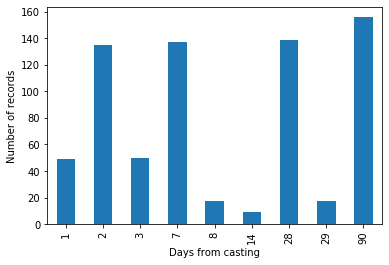

In [152]:
ax = data_melted.groupby("Age").size().plot.bar(color = "tab:blue")
ax.set(xlabel="Days from casting", ylabel="Number of records")

#### Dataset preparations

In [153]:
#2 day
model_data_2 = Model_Data("Data for CatBoost at 2 days",df=data_catboost_union.copy())
model_data_2.select_age(2)
model_data_2.get_X_y_for_age(model_data_cat)

In [154]:
#7 day
model_data_7 = Model_Data("Data for CatBoost at 7 days",df=data_catboost_union.copy())
model_data_7.select_age(7)
model_data_7.get_X_y_for_age(model_data_cat)

In [155]:
#28 day
model_data_28 = Model_Data("Data for CatBoost at 28 days",df=data_catboost_union.copy())
model_data_28.select_age(28)
model_data_28.get_X_y_for_age(model_data_cat)

In [156]:
#90 day
model_data_90 = Model_Data("Data for CatBoost at 90 days",df=data_catboost_union.copy())
model_data_90.select_age(90)
model_data_90.get_X_y_for_age(model_data_cat)

#### Model training on Seperated Ages

In [157]:
def train_predict_catboost(data):
    cat = CatBoostRegressor()
    cat_features = ['CemType',"Age"]
    cat.fit(data.X_train.drop(columns=["ID"]),data.y_train,cat_features)
    predictions_cat = cat.predict(data.X_test.drop(columns=["ID"]))
    data.predictions = predictions_cat
    MAE_cat = mean_absolute_error(np.exp(data.y_test),np.exp(predictions_cat))
    MSE_cat = mean_squared_error(np.exp(data.y_test),np.exp(predictions_cat))
    RMSE_cat = MSE_cat**0.5
    R2_cat = r2_score(np.exp(data.y_test),np.exp(predictions_cat))
    
    return data,cat,MAE_cat, MSE_cat,RMSE_cat,R2_cat

def create_instance_ModelTrainerEvaluator(data,cat,MAE,MSE,RMSE,R2):
    cat_char = ModelCharacteristics(name=data.name,params={},pipeline={})
    cat_evaluator = ModelTrainerEvaluator(model_char=cat_char)
    cat_evaluator.model_data = data
    cat_evaluator.best_estimator = cat
    cat_evaluator.MAE = MAE
    cat_evaluator.MSE = MSE
    cat_evaluator.RMSE = RMSE
    cat_evaluator.R2 = R2
    
    return cat_evaluator

In [158]:
model_containers_ages = {}
for dataset in [model_data_2,model_data_7,model_data_28,model_data_90]:
    data,cat,MAE_cat, MSE_cat,RMSE_cat,R2_cat = train_predict_catboost(dataset)
    cat_evaluator = create_instance_ModelTrainerEvaluator(data,cat,MAE_cat, MSE_cat,RMSE_cat,R2_cat)
    model_containers_ages[dataset.name] = cat_evaluator

Learning rate set to 0.026263
0:	learn: 0.5491903	total: 3.16ms	remaining: 3.16s
1:	learn: 0.5420847	total: 5.01ms	remaining: 2.5s
2:	learn: 0.5358166	total: 7.87ms	remaining: 2.61s
3:	learn: 0.5285856	total: 9.95ms	remaining: 2.48s
4:	learn: 0.5222215	total: 12.9ms	remaining: 2.57s
5:	learn: 0.5149733	total: 15.6ms	remaining: 2.59s
6:	learn: 0.5084260	total: 18.5ms	remaining: 2.62s
7:	learn: 0.5028356	total: 21.9ms	remaining: 2.71s
8:	learn: 0.4968850	total: 24.9ms	remaining: 2.75s
9:	learn: 0.4911532	total: 27.7ms	remaining: 2.75s
10:	learn: 0.4858018	total: 30.5ms	remaining: 2.74s
11:	learn: 0.4802408	total: 33.3ms	remaining: 2.74s
12:	learn: 0.4745098	total: 35.7ms	remaining: 2.71s
13:	learn: 0.4688164	total: 38.1ms	remaining: 2.68s
14:	learn: 0.4632019	total: 40.9ms	remaining: 2.68s
15:	learn: 0.4587124	total: 43.8ms	remaining: 2.69s
16:	learn: 0.4535450	total: 46.4ms	remaining: 2.68s
17:	learn: 0.4490705	total: 49.1ms	remaining: 2.68s
18:	learn: 0.4435774	total: 52.1ms	remaining:

196:	learn: 0.1629262	total: 554ms	remaining: 2.26s
197:	learn: 0.1623254	total: 557ms	remaining: 2.25s
198:	learn: 0.1620828	total: 559ms	remaining: 2.25s
199:	learn: 0.1616446	total: 562ms	remaining: 2.25s
200:	learn: 0.1612739	total: 565ms	remaining: 2.25s
201:	learn: 0.1609075	total: 567ms	remaining: 2.24s
202:	learn: 0.1606398	total: 569ms	remaining: 2.23s
203:	learn: 0.1600783	total: 572ms	remaining: 2.23s
204:	learn: 0.1595911	total: 575ms	remaining: 2.23s
205:	learn: 0.1591690	total: 578ms	remaining: 2.23s
206:	learn: 0.1588137	total: 581ms	remaining: 2.22s
207:	learn: 0.1586323	total: 584ms	remaining: 2.22s
208:	learn: 0.1581496	total: 587ms	remaining: 2.22s
209:	learn: 0.1578493	total: 589ms	remaining: 2.22s
210:	learn: 0.1575294	total: 592ms	remaining: 2.21s
211:	learn: 0.1570957	total: 595ms	remaining: 2.21s
212:	learn: 0.1568203	total: 597ms	remaining: 2.21s
213:	learn: 0.1562911	total: 600ms	remaining: 2.2s
214:	learn: 0.1558848	total: 602ms	remaining: 2.2s
215:	learn: 0.

383:	learn: 0.1125217	total: 1.11s	remaining: 1.78s
384:	learn: 0.1123201	total: 1.11s	remaining: 1.78s
385:	learn: 0.1121022	total: 1.11s	remaining: 1.77s
386:	learn: 0.1120073	total: 1.12s	remaining: 1.77s
387:	learn: 0.1118196	total: 1.12s	remaining: 1.77s
388:	learn: 0.1115356	total: 1.12s	remaining: 1.76s
389:	learn: 0.1112455	total: 1.13s	remaining: 1.76s
390:	learn: 0.1110279	total: 1.13s	remaining: 1.76s
391:	learn: 0.1107315	total: 1.13s	remaining: 1.76s
392:	learn: 0.1105980	total: 1.14s	remaining: 1.76s
393:	learn: 0.1103282	total: 1.14s	remaining: 1.76s
394:	learn: 0.1100792	total: 1.14s	remaining: 1.75s
395:	learn: 0.1098348	total: 1.15s	remaining: 1.75s
396:	learn: 0.1095619	total: 1.15s	remaining: 1.75s
397:	learn: 0.1095222	total: 1.15s	remaining: 1.74s
398:	learn: 0.1093924	total: 1.16s	remaining: 1.74s
399:	learn: 0.1091723	total: 1.16s	remaining: 1.74s
400:	learn: 0.1088848	total: 1.16s	remaining: 1.74s
401:	learn: 0.1087271	total: 1.17s	remaining: 1.73s
402:	learn: 

570:	learn: 0.0825879	total: 1.66s	remaining: 1.25s
571:	learn: 0.0823899	total: 1.67s	remaining: 1.25s
572:	learn: 0.0822109	total: 1.67s	remaining: 1.25s
573:	learn: 0.0819671	total: 1.67s	remaining: 1.24s
574:	learn: 0.0817931	total: 1.68s	remaining: 1.24s
575:	learn: 0.0816216	total: 1.68s	remaining: 1.24s
576:	learn: 0.0814893	total: 1.69s	remaining: 1.24s
577:	learn: 0.0813377	total: 1.69s	remaining: 1.23s
578:	learn: 0.0812002	total: 1.69s	remaining: 1.23s
579:	learn: 0.0809922	total: 1.69s	remaining: 1.23s
580:	learn: 0.0809208	total: 1.7s	remaining: 1.22s
581:	learn: 0.0809081	total: 1.7s	remaining: 1.22s
582:	learn: 0.0808590	total: 1.7s	remaining: 1.22s
583:	learn: 0.0807876	total: 1.71s	remaining: 1.22s
584:	learn: 0.0806440	total: 1.71s	remaining: 1.21s
585:	learn: 0.0805313	total: 1.72s	remaining: 1.21s
586:	learn: 0.0805192	total: 1.72s	remaining: 1.21s
587:	learn: 0.0805075	total: 1.72s	remaining: 1.21s
588:	learn: 0.0803850	total: 1.73s	remaining: 1.21s
589:	learn: 0.0

743:	learn: 0.0654724	total: 2.22s	remaining: 764ms
744:	learn: 0.0654009	total: 2.22s	remaining: 761ms
745:	learn: 0.0652969	total: 2.23s	remaining: 758ms
746:	learn: 0.0652930	total: 2.23s	remaining: 756ms
747:	learn: 0.0652755	total: 2.23s	remaining: 753ms
748:	learn: 0.0651204	total: 2.24s	remaining: 750ms
749:	learn: 0.0649765	total: 2.24s	remaining: 748ms
750:	learn: 0.0649013	total: 2.25s	remaining: 745ms
751:	learn: 0.0648303	total: 2.25s	remaining: 742ms
752:	learn: 0.0647352	total: 2.25s	remaining: 739ms
753:	learn: 0.0646219	total: 2.25s	remaining: 736ms
754:	learn: 0.0645400	total: 2.26s	remaining: 733ms
755:	learn: 0.0644700	total: 2.26s	remaining: 730ms
756:	learn: 0.0643495	total: 2.26s	remaining: 727ms
757:	learn: 0.0642580	total: 2.27s	remaining: 724ms
758:	learn: 0.0642182	total: 2.27s	remaining: 721ms
759:	learn: 0.0641171	total: 2.27s	remaining: 718ms
760:	learn: 0.0640573	total: 2.28s	remaining: 715ms
761:	learn: 0.0640232	total: 2.28s	remaining: 712ms
762:	learn: 

915:	learn: 0.0539930	total: 2.78s	remaining: 255ms
916:	learn: 0.0539830	total: 2.78s	remaining: 252ms
917:	learn: 0.0538980	total: 2.78s	remaining: 249ms
918:	learn: 0.0538363	total: 2.79s	remaining: 246ms
919:	learn: 0.0538098	total: 2.79s	remaining: 243ms
920:	learn: 0.0536693	total: 2.79s	remaining: 240ms
921:	learn: 0.0536619	total: 2.79s	remaining: 237ms
922:	learn: 0.0535894	total: 2.8s	remaining: 234ms
923:	learn: 0.0535444	total: 2.8s	remaining: 231ms
924:	learn: 0.0534088	total: 2.81s	remaining: 228ms
925:	learn: 0.0533053	total: 2.81s	remaining: 224ms
926:	learn: 0.0532680	total: 2.81s	remaining: 221ms
927:	learn: 0.0531892	total: 2.81s	remaining: 218ms
928:	learn: 0.0531327	total: 2.82s	remaining: 215ms
929:	learn: 0.0530390	total: 2.82s	remaining: 212ms
930:	learn: 0.0529845	total: 2.82s	remaining: 209ms
931:	learn: 0.0529607	total: 2.83s	remaining: 206ms
932:	learn: 0.0529146	total: 2.83s	remaining: 203ms
933:	learn: 0.0528295	total: 2.83s	remaining: 200ms
934:	learn: 0.

83:	learn: 0.1805436	total: 242ms	remaining: 2.64s
84:	learn: 0.1792055	total: 246ms	remaining: 2.65s
85:	learn: 0.1780426	total: 250ms	remaining: 2.65s
86:	learn: 0.1770445	total: 254ms	remaining: 2.66s
87:	learn: 0.1761720	total: 257ms	remaining: 2.67s
88:	learn: 0.1753083	total: 261ms	remaining: 2.67s
89:	learn: 0.1739515	total: 265ms	remaining: 2.67s
90:	learn: 0.1730580	total: 269ms	remaining: 2.68s
91:	learn: 0.1722956	total: 272ms	remaining: 2.69s
92:	learn: 0.1715949	total: 276ms	remaining: 2.69s
93:	learn: 0.1704697	total: 279ms	remaining: 2.69s
94:	learn: 0.1698171	total: 283ms	remaining: 2.7s
95:	learn: 0.1689895	total: 287ms	remaining: 2.7s
96:	learn: 0.1682175	total: 290ms	remaining: 2.7s
97:	learn: 0.1674015	total: 294ms	remaining: 2.71s
98:	learn: 0.1667298	total: 297ms	remaining: 2.7s
99:	learn: 0.1657978	total: 301ms	remaining: 2.71s
100:	learn: 0.1649214	total: 305ms	remaining: 2.71s
101:	learn: 0.1638792	total: 308ms	remaining: 2.71s
102:	learn: 0.1629696	total: 312m

258:	learn: 0.1015190	total: 798ms	remaining: 2.28s
259:	learn: 0.1012773	total: 801ms	remaining: 2.28s
260:	learn: 0.1010495	total: 805ms	remaining: 2.28s
261:	learn: 0.1008409	total: 809ms	remaining: 2.28s
262:	learn: 0.1006506	total: 813ms	remaining: 2.28s
263:	learn: 0.1005546	total: 816ms	remaining: 2.28s
264:	learn: 0.1003121	total: 820ms	remaining: 2.27s
265:	learn: 0.1002084	total: 824ms	remaining: 2.27s
266:	learn: 0.1000245	total: 827ms	remaining: 2.27s
267:	learn: 0.0997679	total: 831ms	remaining: 2.27s
268:	learn: 0.0994291	total: 834ms	remaining: 2.27s
269:	learn: 0.0991705	total: 837ms	remaining: 2.26s
270:	learn: 0.0990157	total: 840ms	remaining: 2.26s
271:	learn: 0.0988066	total: 842ms	remaining: 2.25s
272:	learn: 0.0985321	total: 846ms	remaining: 2.25s
273:	learn: 0.0983291	total: 849ms	remaining: 2.25s
274:	learn: 0.0981423	total: 853ms	remaining: 2.25s
275:	learn: 0.0978966	total: 856ms	remaining: 2.25s
276:	learn: 0.0978215	total: 859ms	remaining: 2.24s
277:	learn: 

431:	learn: 0.0720562	total: 1.34s	remaining: 1.77s
432:	learn: 0.0718582	total: 1.35s	remaining: 1.76s
433:	learn: 0.0717560	total: 1.35s	remaining: 1.76s
434:	learn: 0.0716981	total: 1.35s	remaining: 1.76s
435:	learn: 0.0716180	total: 1.36s	remaining: 1.76s
436:	learn: 0.0714420	total: 1.36s	remaining: 1.75s
437:	learn: 0.0713060	total: 1.36s	remaining: 1.75s
438:	learn: 0.0712654	total: 1.37s	remaining: 1.75s
439:	learn: 0.0711378	total: 1.37s	remaining: 1.75s
440:	learn: 0.0709818	total: 1.38s	remaining: 1.74s
441:	learn: 0.0709089	total: 1.38s	remaining: 1.74s
442:	learn: 0.0707733	total: 1.38s	remaining: 1.74s
443:	learn: 0.0706473	total: 1.39s	remaining: 1.74s
444:	learn: 0.0705127	total: 1.39s	remaining: 1.73s
445:	learn: 0.0703912	total: 1.39s	remaining: 1.73s
446:	learn: 0.0702670	total: 1.39s	remaining: 1.73s
447:	learn: 0.0701411	total: 1.4s	remaining: 1.72s
448:	learn: 0.0701153	total: 1.4s	remaining: 1.72s
449:	learn: 0.0700177	total: 1.4s	remaining: 1.72s
450:	learn: 0.0

608:	learn: 0.0565450	total: 1.91s	remaining: 1.22s
609:	learn: 0.0564829	total: 1.91s	remaining: 1.22s
610:	learn: 0.0564573	total: 1.91s	remaining: 1.22s
611:	learn: 0.0564486	total: 1.92s	remaining: 1.22s
612:	learn: 0.0563763	total: 1.92s	remaining: 1.21s
613:	learn: 0.0563193	total: 1.92s	remaining: 1.21s
614:	learn: 0.0562897	total: 1.93s	remaining: 1.21s
615:	learn: 0.0561937	total: 1.93s	remaining: 1.2s
616:	learn: 0.0561327	total: 1.93s	remaining: 1.2s
617:	learn: 0.0560698	total: 1.94s	remaining: 1.2s
618:	learn: 0.0560082	total: 1.94s	remaining: 1.19s
619:	learn: 0.0559575	total: 1.94s	remaining: 1.19s
620:	learn: 0.0559404	total: 1.95s	remaining: 1.19s
621:	learn: 0.0558254	total: 1.95s	remaining: 1.18s
622:	learn: 0.0557431	total: 1.95s	remaining: 1.18s
623:	learn: 0.0556627	total: 1.96s	remaining: 1.18s
624:	learn: 0.0556073	total: 1.96s	remaining: 1.18s
625:	learn: 0.0555308	total: 1.96s	remaining: 1.17s
626:	learn: 0.0554740	total: 1.97s	remaining: 1.17s
627:	learn: 0.0

780:	learn: 0.0465733	total: 2.47s	remaining: 692ms
781:	learn: 0.0464804	total: 2.47s	remaining: 689ms
782:	learn: 0.0464388	total: 2.47s	remaining: 686ms
783:	learn: 0.0464196	total: 2.48s	remaining: 682ms
784:	learn: 0.0463891	total: 2.48s	remaining: 679ms
785:	learn: 0.0463626	total: 2.48s	remaining: 676ms
786:	learn: 0.0463421	total: 2.49s	remaining: 673ms
787:	learn: 0.0463145	total: 2.49s	remaining: 670ms
788:	learn: 0.0462762	total: 2.49s	remaining: 667ms
789:	learn: 0.0462570	total: 2.5s	remaining: 663ms
790:	learn: 0.0462200	total: 2.5s	remaining: 660ms
791:	learn: 0.0461811	total: 2.5s	remaining: 657ms
792:	learn: 0.0461130	total: 2.51s	remaining: 654ms
793:	learn: 0.0461051	total: 2.51s	remaining: 651ms
794:	learn: 0.0460187	total: 2.51s	remaining: 648ms
795:	learn: 0.0459568	total: 2.52s	remaining: 645ms
796:	learn: 0.0459296	total: 2.52s	remaining: 642ms
797:	learn: 0.0458932	total: 2.52s	remaining: 638ms
798:	learn: 0.0458379	total: 2.52s	remaining: 635ms
799:	learn: 0.0

953:	learn: 0.0399473	total: 3.03s	remaining: 146ms
954:	learn: 0.0399115	total: 3.03s	remaining: 143ms
955:	learn: 0.0398888	total: 3.03s	remaining: 140ms
956:	learn: 0.0398230	total: 3.04s	remaining: 137ms
957:	learn: 0.0398116	total: 3.04s	remaining: 133ms
958:	learn: 0.0397610	total: 3.04s	remaining: 130ms
959:	learn: 0.0397319	total: 3.05s	remaining: 127ms
960:	learn: 0.0397124	total: 3.05s	remaining: 124ms
961:	learn: 0.0396540	total: 3.05s	remaining: 121ms
962:	learn: 0.0395991	total: 3.06s	remaining: 117ms
963:	learn: 0.0395423	total: 3.06s	remaining: 114ms
964:	learn: 0.0395102	total: 3.06s	remaining: 111ms
965:	learn: 0.0394698	total: 3.07s	remaining: 108ms
966:	learn: 0.0394321	total: 3.07s	remaining: 105ms
967:	learn: 0.0394137	total: 3.07s	remaining: 102ms
968:	learn: 0.0393928	total: 3.08s	remaining: 98.4ms
969:	learn: 0.0393648	total: 3.08s	remaining: 95.2ms
970:	learn: 0.0393521	total: 3.08s	remaining: 92.1ms
971:	learn: 0.0393287	total: 3.08s	remaining: 88.9ms
972:	lea

149:	learn: 0.0983977	total: 374ms	remaining: 2.12s
150:	learn: 0.0980368	total: 377ms	remaining: 2.12s
151:	learn: 0.0977081	total: 379ms	remaining: 2.12s
152:	learn: 0.0972939	total: 382ms	remaining: 2.12s
153:	learn: 0.0970428	total: 385ms	remaining: 2.11s
154:	learn: 0.0967258	total: 388ms	remaining: 2.11s
155:	learn: 0.0962965	total: 390ms	remaining: 2.11s
156:	learn: 0.0960488	total: 393ms	remaining: 2.11s
157:	learn: 0.0958161	total: 397ms	remaining: 2.11s
158:	learn: 0.0955171	total: 400ms	remaining: 2.11s
159:	learn: 0.0951800	total: 403ms	remaining: 2.11s
160:	learn: 0.0947995	total: 405ms	remaining: 2.11s
161:	learn: 0.0943949	total: 408ms	remaining: 2.11s
162:	learn: 0.0941220	total: 410ms	remaining: 2.11s
163:	learn: 0.0938933	total: 413ms	remaining: 2.11s
164:	learn: 0.0936650	total: 416ms	remaining: 2.1s
165:	learn: 0.0934899	total: 418ms	remaining: 2.1s
166:	learn: 0.0932615	total: 420ms	remaining: 2.1s
167:	learn: 0.0929121	total: 423ms	remaining: 2.09s
168:	learn: 0.0

369:	learn: 0.0623032	total: 925ms	remaining: 1.57s
370:	learn: 0.0621916	total: 927ms	remaining: 1.57s
371:	learn: 0.0620746	total: 929ms	remaining: 1.57s
372:	learn: 0.0620361	total: 931ms	remaining: 1.56s
373:	learn: 0.0619476	total: 933ms	remaining: 1.56s
374:	learn: 0.0619004	total: 936ms	remaining: 1.56s
375:	learn: 0.0618013	total: 938ms	remaining: 1.56s
376:	learn: 0.0616355	total: 941ms	remaining: 1.55s
377:	learn: 0.0615780	total: 944ms	remaining: 1.55s
378:	learn: 0.0615320	total: 946ms	remaining: 1.55s
379:	learn: 0.0614235	total: 949ms	remaining: 1.55s
380:	learn: 0.0613839	total: 951ms	remaining: 1.54s
381:	learn: 0.0613442	total: 953ms	remaining: 1.54s
382:	learn: 0.0612248	total: 955ms	remaining: 1.54s
383:	learn: 0.0611795	total: 958ms	remaining: 1.54s
384:	learn: 0.0610264	total: 960ms	remaining: 1.53s
385:	learn: 0.0609229	total: 961ms	remaining: 1.53s
386:	learn: 0.0607764	total: 964ms	remaining: 1.53s
387:	learn: 0.0606700	total: 966ms	remaining: 1.52s
388:	learn: 

530:	learn: 0.0524184	total: 1.29s	remaining: 1.14s
531:	learn: 0.0523858	total: 1.29s	remaining: 1.14s
532:	learn: 0.0523253	total: 1.3s	remaining: 1.14s
533:	learn: 0.0522035	total: 1.3s	remaining: 1.13s
534:	learn: 0.0521823	total: 1.3s	remaining: 1.13s
535:	learn: 0.0521444	total: 1.3s	remaining: 1.13s
536:	learn: 0.0520821	total: 1.31s	remaining: 1.13s
537:	learn: 0.0520535	total: 1.31s	remaining: 1.12s
538:	learn: 0.0520050	total: 1.31s	remaining: 1.12s
539:	learn: 0.0519738	total: 1.31s	remaining: 1.12s
540:	learn: 0.0519463	total: 1.32s	remaining: 1.12s
541:	learn: 0.0519378	total: 1.32s	remaining: 1.12s
542:	learn: 0.0518590	total: 1.32s	remaining: 1.11s
543:	learn: 0.0518375	total: 1.33s	remaining: 1.11s
544:	learn: 0.0518100	total: 1.33s	remaining: 1.11s
545:	learn: 0.0517802	total: 1.33s	remaining: 1.11s
546:	learn: 0.0517531	total: 1.33s	remaining: 1.1s
547:	learn: 0.0516261	total: 1.33s	remaining: 1.1s
548:	learn: 0.0515861	total: 1.34s	remaining: 1.1s
549:	learn: 0.05155

758:	learn: 0.0445607	total: 1.85s	remaining: 586ms
759:	learn: 0.0445550	total: 1.85s	remaining: 584ms
760:	learn: 0.0445407	total: 1.85s	remaining: 581ms
761:	learn: 0.0445164	total: 1.85s	remaining: 579ms
762:	learn: 0.0444730	total: 1.85s	remaining: 576ms
763:	learn: 0.0444517	total: 1.86s	remaining: 574ms
764:	learn: 0.0444436	total: 1.86s	remaining: 571ms
765:	learn: 0.0444344	total: 1.86s	remaining: 569ms
766:	learn: 0.0443748	total: 1.86s	remaining: 566ms
767:	learn: 0.0443505	total: 1.87s	remaining: 564ms
768:	learn: 0.0443431	total: 1.87s	remaining: 561ms
769:	learn: 0.0443339	total: 1.87s	remaining: 559ms
770:	learn: 0.0442885	total: 1.87s	remaining: 556ms
771:	learn: 0.0442684	total: 1.88s	remaining: 554ms
772:	learn: 0.0441545	total: 1.88s	remaining: 551ms
773:	learn: 0.0441474	total: 1.88s	remaining: 549ms
774:	learn: 0.0441010	total: 1.88s	remaining: 547ms
775:	learn: 0.0440776	total: 1.89s	remaining: 544ms
776:	learn: 0.0440631	total: 1.89s	remaining: 541ms
777:	learn: 

992:	learn: 0.0386835	total: 2.4s	remaining: 16.9ms
993:	learn: 0.0386732	total: 2.4s	remaining: 14.5ms
994:	learn: 0.0386664	total: 2.4s	remaining: 12.1ms
995:	learn: 0.0385624	total: 2.4s	remaining: 9.66ms
996:	learn: 0.0385426	total: 2.41s	remaining: 7.25ms
997:	learn: 0.0385233	total: 2.41s	remaining: 4.83ms
998:	learn: 0.0384292	total: 2.41s	remaining: 2.41ms
999:	learn: 0.0384222	total: 2.41s	remaining: 0us
Learning rate set to 0.026956
0:	learn: 0.2191980	total: 2.42ms	remaining: 2.42s
1:	learn: 0.2167726	total: 5.01ms	remaining: 2.5s
2:	learn: 0.2141428	total: 7.81ms	remaining: 2.6s
3:	learn: 0.2124050	total: 10.5ms	remaining: 2.61s
4:	learn: 0.2102003	total: 13.1ms	remaining: 2.62s
5:	learn: 0.2079929	total: 15.7ms	remaining: 2.6s
6:	learn: 0.2053854	total: 18.3ms	remaining: 2.59s
7:	learn: 0.2031117	total: 20.7ms	remaining: 2.57s
8:	learn: 0.2010745	total: 23.2ms	remaining: 2.56s
9:	learn: 0.1994241	total: 25.7ms	remaining: 2.54s
10:	learn: 0.1977529	total: 28.2ms	remaining: 

213:	learn: 0.0834623	total: 499ms	remaining: 1.83s
214:	learn: 0.0832609	total: 502ms	remaining: 1.83s
215:	learn: 0.0830163	total: 504ms	remaining: 1.83s
216:	learn: 0.0827684	total: 508ms	remaining: 1.83s
217:	learn: 0.0826905	total: 510ms	remaining: 1.83s
218:	learn: 0.0825036	total: 513ms	remaining: 1.83s
219:	learn: 0.0824029	total: 515ms	remaining: 1.83s
220:	learn: 0.0822360	total: 517ms	remaining: 1.82s
221:	learn: 0.0819699	total: 520ms	remaining: 1.82s
222:	learn: 0.0818105	total: 523ms	remaining: 1.82s
223:	learn: 0.0816611	total: 525ms	remaining: 1.82s
224:	learn: 0.0815224	total: 528ms	remaining: 1.82s
225:	learn: 0.0812851	total: 531ms	remaining: 1.82s
226:	learn: 0.0811301	total: 533ms	remaining: 1.81s
227:	learn: 0.0810563	total: 535ms	remaining: 1.81s
228:	learn: 0.0808915	total: 538ms	remaining: 1.81s
229:	learn: 0.0807871	total: 541ms	remaining: 1.81s
230:	learn: 0.0806828	total: 543ms	remaining: 1.81s
231:	learn: 0.0805210	total: 546ms	remaining: 1.81s
232:	learn: 

436:	learn: 0.0597111	total: 1.05s	remaining: 1.36s
437:	learn: 0.0596978	total: 1.06s	remaining: 1.36s
438:	learn: 0.0596340	total: 1.06s	remaining: 1.35s
439:	learn: 0.0595885	total: 1.06s	remaining: 1.35s
440:	learn: 0.0595463	total: 1.06s	remaining: 1.35s
441:	learn: 0.0595131	total: 1.07s	remaining: 1.35s
442:	learn: 0.0594106	total: 1.07s	remaining: 1.35s
443:	learn: 0.0593819	total: 1.07s	remaining: 1.34s
444:	learn: 0.0593686	total: 1.07s	remaining: 1.34s
445:	learn: 0.0593486	total: 1.08s	remaining: 1.34s
446:	learn: 0.0592849	total: 1.08s	remaining: 1.34s
447:	learn: 0.0592008	total: 1.08s	remaining: 1.33s
448:	learn: 0.0591717	total: 1.08s	remaining: 1.33s
449:	learn: 0.0591550	total: 1.09s	remaining: 1.33s
450:	learn: 0.0590300	total: 1.09s	remaining: 1.33s
451:	learn: 0.0589865	total: 1.09s	remaining: 1.32s
452:	learn: 0.0589225	total: 1.09s	remaining: 1.32s
453:	learn: 0.0587990	total: 1.1s	remaining: 1.32s
454:	learn: 0.0587789	total: 1.1s	remaining: 1.32s
455:	learn: 0.

599:	learn: 0.0523318	total: 1.43s	remaining: 953ms
600:	learn: 0.0523084	total: 1.43s	remaining: 951ms
601:	learn: 0.0522870	total: 1.43s	remaining: 949ms
602:	learn: 0.0522654	total: 1.44s	remaining: 946ms
603:	learn: 0.0522466	total: 1.44s	remaining: 944ms
604:	learn: 0.0522159	total: 1.44s	remaining: 941ms
605:	learn: 0.0521451	total: 1.44s	remaining: 939ms
606:	learn: 0.0521168	total: 1.45s	remaining: 937ms
607:	learn: 0.0520428	total: 1.45s	remaining: 934ms
608:	learn: 0.0519532	total: 1.45s	remaining: 932ms
609:	learn: 0.0519242	total: 1.46s	remaining: 931ms
610:	learn: 0.0518768	total: 1.46s	remaining: 929ms
611:	learn: 0.0518517	total: 1.46s	remaining: 926ms
612:	learn: 0.0518273	total: 1.46s	remaining: 924ms
613:	learn: 0.0517745	total: 1.47s	remaining: 921ms
614:	learn: 0.0517265	total: 1.47s	remaining: 919ms
615:	learn: 0.0516617	total: 1.47s	remaining: 917ms
616:	learn: 0.0516143	total: 1.47s	remaining: 915ms
617:	learn: 0.0516081	total: 1.48s	remaining: 912ms
618:	learn: 

762:	learn: 0.0471471	total: 1.8s	remaining: 559ms
763:	learn: 0.0471236	total: 1.8s	remaining: 557ms
764:	learn: 0.0471177	total: 1.8s	remaining: 555ms
765:	learn: 0.0470912	total: 1.81s	remaining: 552ms
766:	learn: 0.0470753	total: 1.81s	remaining: 550ms
767:	learn: 0.0470326	total: 1.81s	remaining: 547ms
768:	learn: 0.0470014	total: 1.81s	remaining: 545ms
769:	learn: 0.0469745	total: 1.82s	remaining: 543ms
770:	learn: 0.0469436	total: 1.82s	remaining: 540ms
771:	learn: 0.0469259	total: 1.82s	remaining: 538ms
772:	learn: 0.0468761	total: 1.82s	remaining: 535ms
773:	learn: 0.0468258	total: 1.82s	remaining: 533ms
774:	learn: 0.0467875	total: 1.83s	remaining: 531ms
775:	learn: 0.0467281	total: 1.83s	remaining: 528ms
776:	learn: 0.0467101	total: 1.83s	remaining: 526ms
777:	learn: 0.0466661	total: 1.83s	remaining: 524ms
778:	learn: 0.0466642	total: 1.84s	remaining: 521ms
779:	learn: 0.0466081	total: 1.84s	remaining: 519ms
780:	learn: 0.0465641	total: 1.84s	remaining: 516ms
781:	learn: 0.0

973:	learn: 0.0421573	total: 2.31s	remaining: 61.6ms
974:	learn: 0.0420856	total: 2.31s	remaining: 59.2ms
975:	learn: 0.0420624	total: 2.31s	remaining: 56.8ms
976:	learn: 0.0420292	total: 2.31s	remaining: 54.5ms
977:	learn: 0.0420256	total: 2.31s	remaining: 52.1ms
978:	learn: 0.0419906	total: 2.32s	remaining: 49.7ms
979:	learn: 0.0419515	total: 2.32s	remaining: 47.4ms
980:	learn: 0.0419364	total: 2.32s	remaining: 45ms
981:	learn: 0.0419315	total: 2.33s	remaining: 42.6ms
982:	learn: 0.0419306	total: 2.33s	remaining: 40.3ms
983:	learn: 0.0419224	total: 2.33s	remaining: 37.9ms
984:	learn: 0.0419181	total: 2.33s	remaining: 35.5ms
985:	learn: 0.0419096	total: 2.33s	remaining: 33.2ms
986:	learn: 0.0419011	total: 2.34s	remaining: 30.8ms
987:	learn: 0.0418621	total: 2.34s	remaining: 28.4ms
988:	learn: 0.0418418	total: 2.34s	remaining: 26.1ms
989:	learn: 0.0418240	total: 2.34s	remaining: 23.7ms
990:	learn: 0.0418036	total: 2.35s	remaining: 21.3ms
991:	learn: 0.0417942	total: 2.35s	remaining: 19

#### Best predictions of models trained on seperated ages

In [159]:
seperated_days_MSE = {}
seperated_days_RMSE = {}

for model_trainer_evaluator in model_containers_ages.values():
    k = model_trainer_evaluator.model_data.applied_age
    v = model_trainer_evaluator.MSE.round(2)
    seperated_days_MSE[k] = v
    
for model_trainer_evaluator in model_containers_ages.values():
    k = model_trainer_evaluator.model_data.applied_age
    v = model_trainer_evaluator.RMSE.round(2)
    seperated_days_RMSE[k] = v
    
print(f"Training on separeted ages: MSE:{seperated_days_MSE}")
print(f"Training on separeted ages: RMSE:{seperated_days_RMSE}")     

Training on separeted ages: MSE:{2: 24.18, 7: 48.4, 28: 32.78, 90: 46.46}
Training on separeted ages: RMSE:{2: 4.92, 7: 6.96, 28: 5.73, 90: 6.82}


### Comparison of model's accuracies using all ages and seperate ages 

In [160]:
ages = [2,7,28,90]

for age in ages:
    if age_subMSE[age] < seperated_days_MSE[age]:
        print(f"At day {age}, lower MSE was achieved using all data (all ages).")
    else:
        print(f"At day {age}, lower MSE was achieved using only data at {age} age.")

At day 2, lower MSE was achieved using only data at 2 age.
At day 7, lower MSE was achieved using all data (all ages).
At day 28, lower MSE was achieved using all data (all ages).
At day 90, lower MSE was achieved using all data (all ages).


## Visualization of the prediction analysis

In [64]:
best_predictor = model_container.best_model_evaluation
y_pred = np.exp(best_predictor.model_data.predictions)
y_test = np.exp(best_predictor.model_data.y_test)

In [65]:
#Predictons/measurements on test data
def plot_comparison_trainpred_test_pred(y_test,y_pred): 
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(y_test,y_pred, alpha=0.4, color = "b");
    #ax1.set_title('Measured and predicted compressive strength at all ages on train data')
    ax1.set_xlabel("Measured compressive strength [MPa]")
    ax1.set_ylabel("Predicted compressive strength [MPa]");

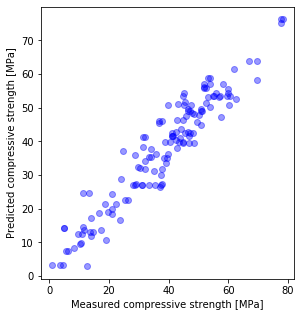

In [66]:
plot_comparison_trainpred_test_pred(y_test,y_pred)

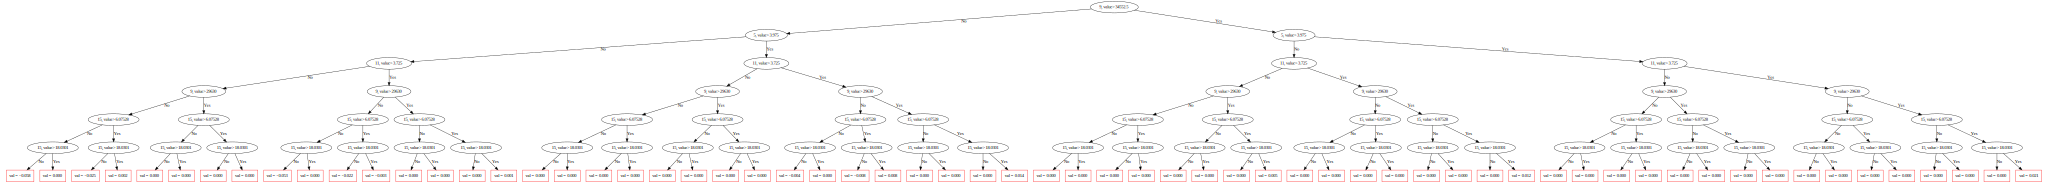

In [67]:
best_predictor.best_estimator.plot_tree(tree_idx=0)

In [68]:
xbm_model = model_container.models_evaluations[2].best_estimator.named_steps["xbm"]
X_test_feature_importance = model_container.models_evaluations[2].model_data.X_test.drop(columns=["ID","Age"])

In [69]:
def plot_feature_importance(X_test,model,title):
    feats = {}
    for feature, importance in zip(X_test.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90,figsize=(15,5),title=title)

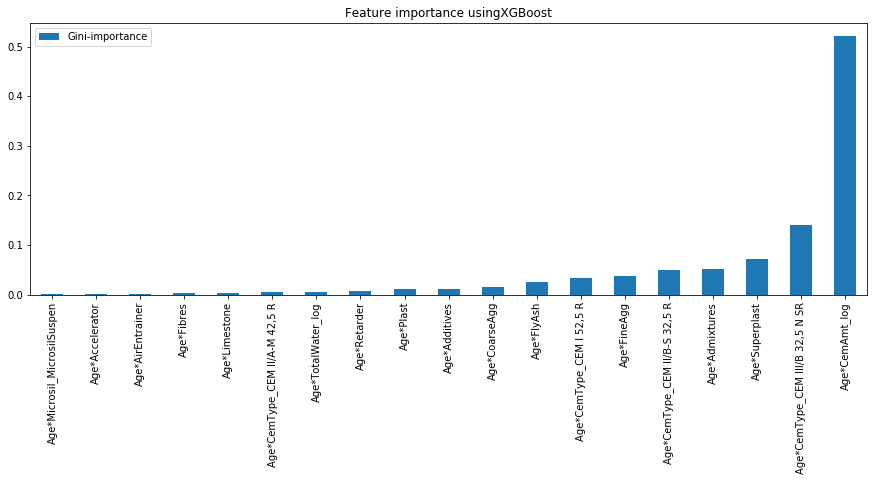

In [70]:
plot_feature_importance(X_test_feature_importance,xbm_model,"Feature importance usingXGBoost")

## Exporting Trained Model and Metrics

In [166]:
import _pickle as cPickle

In [167]:
export_model = {"model": model_container.best_model_evaluation.best_estimator,
                "data" : data_catboost_union,
               "MSE":age_subMSE,
               "RMSE":age_subRMSE}

In [168]:
with open(r"trained_model_metrics.pickle", "wb") as output_file:
    cPickle.dump(export_model, output_file)